<a href="https://colab.research.google.com/github/ziatdinovmax/gpax/blob/main/examples/gpax_viDKL_plasmons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep kernel learning for data reconstruction and automated experiment
This notebook demonstrates how to use a deep kernel learning with variational inference (viDKL) for data reconstruction and automated experiments. We will be using the pre-acquired experimental dataset on plasmonic nanoparticles (HAADF + EELS) from Kevin Roccapriore.

*Prepared by Maxim Ziatdinov (January 2022)*

Installations:

In [ ]:
!pip install -q --upgrade git+https://github.com/ziatdinovmax/gpax@v0.0.3
!pip install -q atomai  # we will use the atomai's utility function for preparing the input data

Imports:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra

gpax.utils.enable_x64()

Download training data:

In [4]:
!wget -qq https://www.dropbox.com/s/1tguc2zraiyxg7h/Plasmonic_EELS_FITO0_edgehole_01.npy

Load data into the notebook:

In [5]:
loadedfile = np.load("Plasmonic_EELS_FITO0_edgehole_01.npy", allow_pickle=True).tolist()
for key, value in loadedfile.items():
  print(key, value.shape)

image (62, 75)
spectrum image (62, 75, 1496)
energy axis (1496,)
scale ()


In [6]:
img = loadedfile['image']
specim = loadedfile['spectrum image']
e_ax = loadedfile['energy axis']
imscale = loadedfile['scale']

Generate training inputs (image patches) and targets (spectra).

In [7]:
window_size = 16

coordinates = get_coord_grid(img, step=1, return_dict=False)
features, targets, indices = extract_patches_and_spectra(
    specim, img, coordinates=coordinates, window_size=window_size, avg_pool=16)

features.shape, targets.shape

/usr/local/lib/python3.7/dist-packages/atomai/utils/img.py:450: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  spectra = torch.tensor(spectra).unsqueeze(1)


((2820, 16, 16), (2820, 93))

Normalize data:

In [8]:
norm_ = lambda x: (x - x.min()) / x.ptp()
features, targets = norm_(features), norm_(targets)

Let's scalarize our vactor-valued targets. Here we are going to do the scalarization by simply using the intensity of largest plasmonic peak but more sophisticated scalar descritpors can be derived as well (ratio of peaks, etc.). First do it for a single spectrum:

25 0.2826059331244979


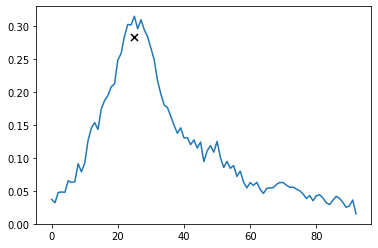

In [9]:
k = 1
peak_data = find_peaks(targets[k], width=5)
peak_pos, peak_int = peak_data[0][0], peak_data[1]['prominences'][0]
plt.plot(targets[k], zorder=0)
print(peak_pos, peak_int)
plt.scatter(peak_pos, peak_int, marker='x', s=50, c='k', zorder=1)

Same but for all the data:

In [10]:
peaks_all, features_all, indices_all = [], [], []
for i, t in enumerate(targets):
    peak = find_peaks(t, width=5)[1]["prominences"]
    if len(peak) == 0:
        continue
    peaks_all.append(np.array([peak[0]]) if len(peak) > 1 else peak)
    features_all.append(features[i])
    indices_all.append(indices[i])
peaks_all = np.concatenate(peaks_all)
features_all = np.array(features_all)
indices_all = np.array(indices_all)

Plot the scalarized target values for each feature coordinate:

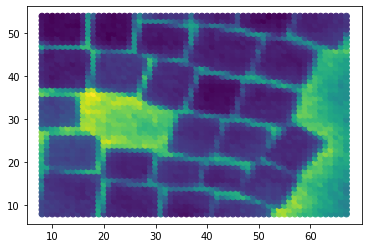

In [11]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all)

## DKL on full data

Prepare data for training:

In [12]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

Train:

In [13]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X, y, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:07<00:00, 13.75it/s, init loss: 23205.6149, avg. loss [96-100]: 15888.3928]



Inferred GP kernel parameters
k_length         [18.8629  9.8054]
k_scale          0.1381
noise            0.0103


Make a "prediction" on the training data (since we used all the data for training, our training and test datasets are the same, that is, we basically look at how well our model was able to "fit" the data):

In [14]:
mean, var = dkl.predict(key2, X)

Text(0.5, 1.0, 'DKL uncertainty')

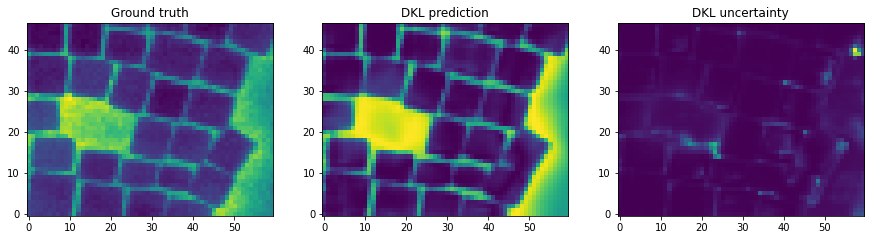

In [15]:
s1, s2 = img.shape[0] - window_size+1, img.shape[1] - window_size+1

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.imshow(peaks_all.reshape(s1, s2), origin="lower")
ax1.set_title("Ground truth")
ax2.imshow(mean.reshape(s1, s2))
ax2.set_title("DKL prediction")
ax2.imshow(mean.reshape(s1, s2), origin="lower")
ax3.imshow(var.reshape(s1, s2), origin="lower")
ax3.set_title("DKL uncertainty")

We can also visualize our latent/embedding space:

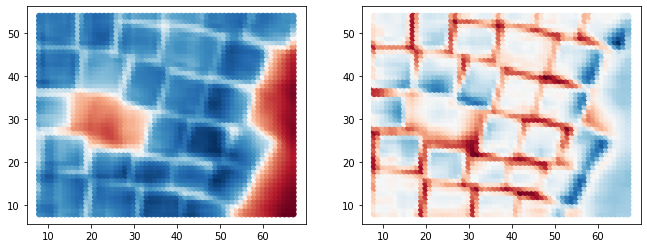

In [16]:
embeded = dkl.embed(X)
embeded = embeded / embeded.max()

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 0], cmap='RdBu')
ax2.scatter(indices_all[:, 1], indices_all[:, 0], c=embeded[:, 1], cmap='RdBu')

## DKL on partial data

Now let's use only a part of the data for training:

In [17]:
split_ = 25
X_train = X[indices_all[:, 1] < split_]
y_train = y[indices_all[:, 1] < split_]
indices_train = indices_all[indices_all[:, 1] < split_]

In [18]:
data_dim = X.shape[-1]

key1, key2 = gpax.utils.get_keys()

dkl = gpax.viDKL(data_dim, z_dim=2, kernel='RBF')
dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)

100%|██████████| 100/100 [00:02<00:00, 40.27it/s, init loss: 21019.9002, avg. loss [96-100]: 18435.9513]


Inferred GP kernel parameters
k_length         [35.9124 35.0233]
k_scale          0.1265
noise            0.014100000000000001


In [19]:
mean, var = dkl.predict(key2, X)

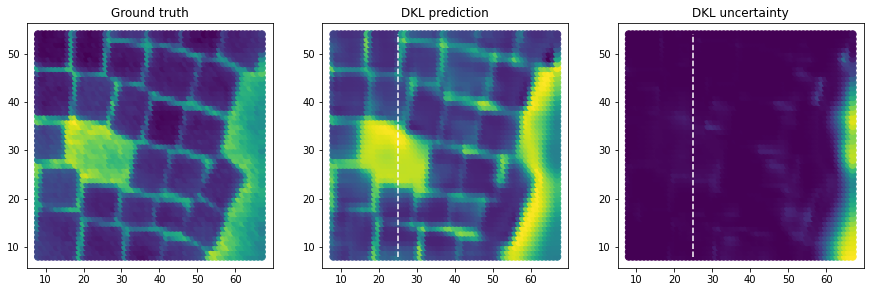

In [20]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4.5))
ax1.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=peaks_all)
ax1.set_title("Ground truth")
ax2.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=mean)
ax2.set_title("DKL prediction")
ax3.scatter(indices_all[:, 1], indices_all[:, 0], s=50, c=var)
ax3.set_title("DKL uncertainty")
ax2.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')
ax3.vlines(split_, indices_all[:, 0].min(), indices_all[:, 0].max(), linestyle='--', color='w')

## Active learning

Here we are going to use DKL for active learning aimed at identifying regions of the sample where a particular behavior (plasmon resonance peak) is maximized. We start with just a few "measured" points:

In [21]:
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)
y = peaks_all
X.shape, y.shape

((2820, 256), (2820,))

In [22]:
# Here X_train and y_train are our measured image patches (HAADF) and spectra/peaks (EELS),
# whereas X_test and y_test are the "unkwown" ones. The indices_train are grid coordinates of the measured points,
# whereas the indices_test are the grid coordinates of the remaining available points on the grid
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_train)

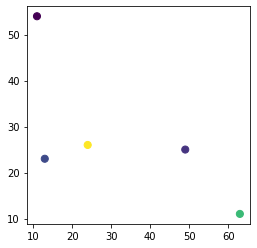

In [23]:
plt.figure(figsize=(4, 4))
plt.scatter(indices_train[:, 1], indices_train[:, 0], s=50, c=y_train)

Do sample exploration based on the pre-acquired data (i.e., we are running a "dummy" experiment):

1/80


100%|██████████| 100/100 [00:01<00:00, 56.85it/s, init loss: 20124.5998, avg. loss [96-100]: 19061.5936]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2994
noise            0.1452


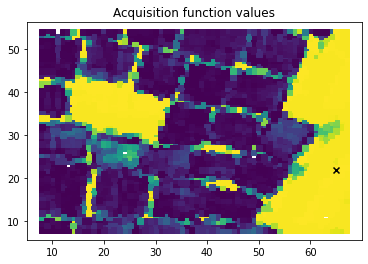

2/80


100%|██████████| 100/100 [00:02<00:00, 48.71it/s, init loss: 20125.9706, avg. loss [96-100]: 19061.8815]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3135
noise            0.12940000000000002


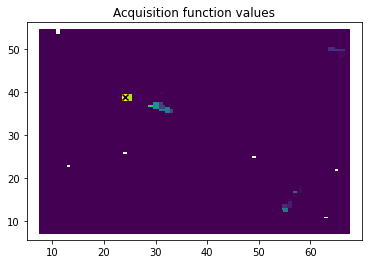

3/80


100%|██████████| 100/100 [00:01<00:00, 55.40it/s, init loss: 20127.2217, avg. loss [96-100]: 19061.9581]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30410000000000004
noise            0.11470000000000001


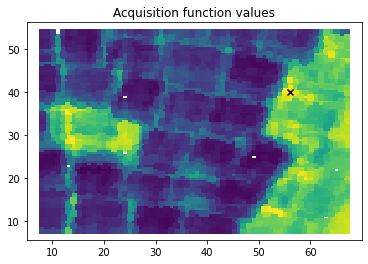

4/80


100%|██████████| 100/100 [00:01<00:00, 52.22it/s, init loss: 20128.4775, avg. loss [96-100]: 19061.9043]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.2969
noise            0.10250000000000001


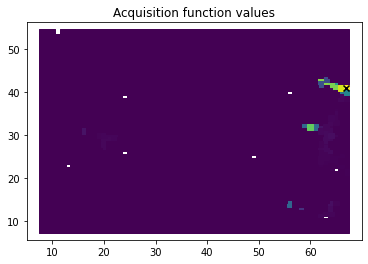

5/80


100%|██████████| 100/100 [00:01<00:00, 53.55it/s, init loss: 20129.8032, avg. loss [96-100]: 19061.8481]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3027
noise            0.0922


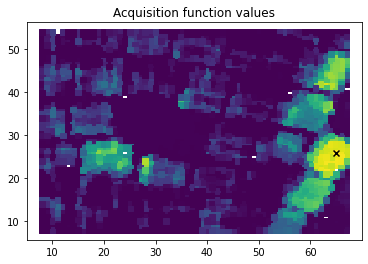

6/80


100%|██████████| 100/100 [00:01<00:00, 51.33it/s, init loss: 20131.0593, avg. loss [96-100]: 19061.8685]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30970000000000003
noise            0.0862


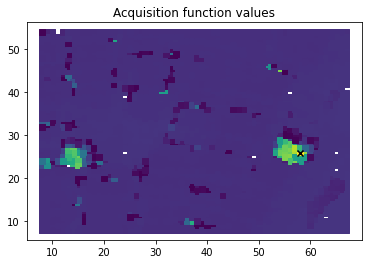

7/80


100%|██████████| 100/100 [00:01<00:00, 53.34it/s, init loss: 20132.3208, avg. loss [96-100]: 19061.7580]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3042
noise            0.0806


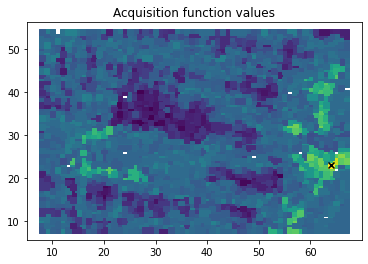

8/80


100%|██████████| 100/100 [00:02<00:00, 49.19it/s, init loss: 20133.7329, avg. loss [96-100]: 19062.3121]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3145
noise            0.0855


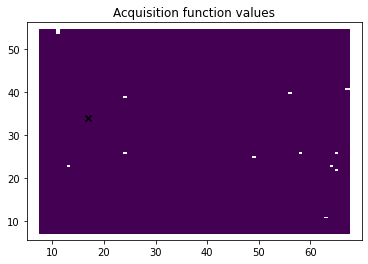

9/80


100%|██████████| 100/100 [00:01<00:00, 52.32it/s, init loss: 20135.0701, avg. loss [96-100]: 19063.1053]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3261
noise            0.0935


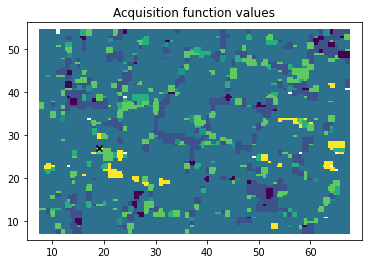

10/80


100%|██████████| 100/100 [00:01<00:00, 50.33it/s, init loss: 20136.4550, avg. loss [96-100]: 19063.3254]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.33390000000000003
noise            0.0927


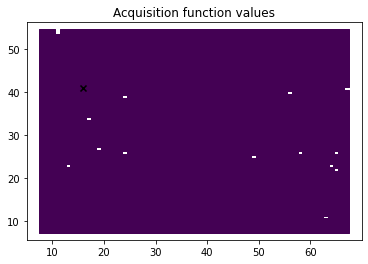

11/80


100%|██████████| 100/100 [00:01<00:00, 51.58it/s, init loss: 20137.7078, avg. loss [96-100]: 19063.5767]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32630000000000003
noise            0.093


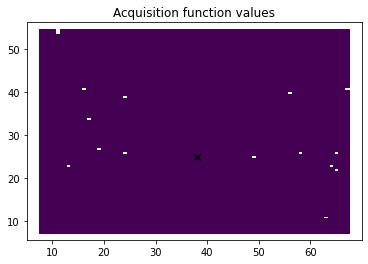

12/80


100%|██████████| 100/100 [00:02<00:00, 48.31it/s, init loss: 20138.9685, avg. loss [96-100]: 19063.6311]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3209
noise            0.0906


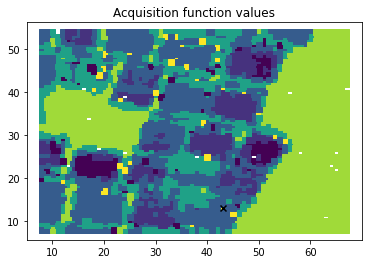

13/80


100%|██████████| 100/100 [00:01<00:00, 51.54it/s, init loss: 20140.1970, avg. loss [96-100]: 19063.4657]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.32370000000000004
noise            0.0857


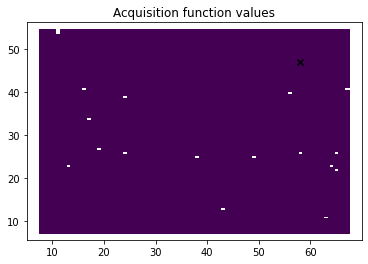

14/80


100%|██████████| 100/100 [00:02<00:00, 47.05it/s, init loss: 20141.3523, avg. loss [96-100]: 19063.4287]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31930000000000003
noise            0.08360000000000001


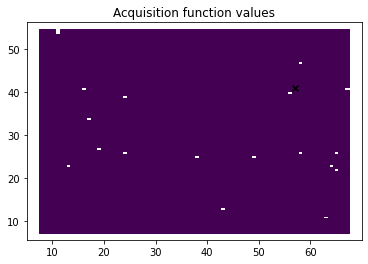

15/80


100%|██████████| 100/100 [00:02<00:00, 49.60it/s, init loss: 20142.6071, avg. loss [96-100]: 19063.4957]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3148
noise            0.0825


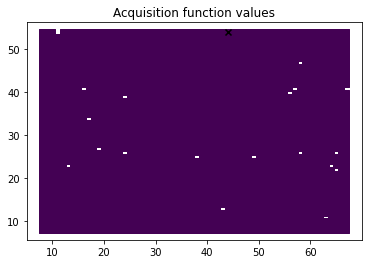

16/80


100%|██████████| 100/100 [00:02<00:00, 44.13it/s, init loss: 20143.8595, avg. loss [96-100]: 19063.6021]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.31010000000000004
noise            0.082


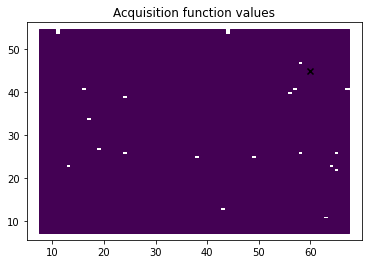

17/80


100%|██████████| 100/100 [00:02<00:00, 42.95it/s, init loss: 20145.1169, avg. loss [96-100]: 19063.5768]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30670000000000003
noise            0.08030000000000001


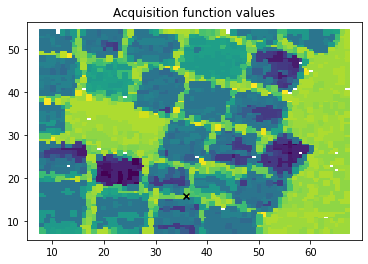

18/80


100%|██████████| 100/100 [00:02<00:00, 45.53it/s, init loss: 20146.3089, avg. loss [96-100]: 19063.4991]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3039
noise            0.07830000000000001


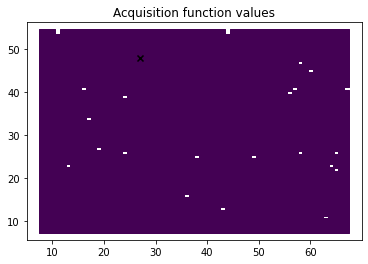

19/80


100%|██████████| 100/100 [00:02<00:00, 47.61it/s, init loss: 20147.5102, avg. loss [96-100]: 19063.3688]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.301
noise            0.07640000000000001


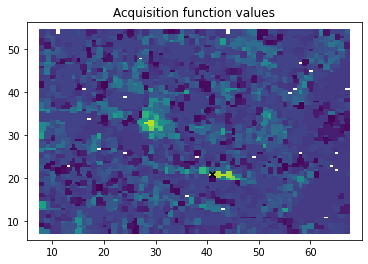

20/80


100%|██████████| 100/100 [00:02<00:00, 42.49it/s, init loss: 20148.8402, avg. loss [96-100]: 19063.1784]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3034
noise            0.0741


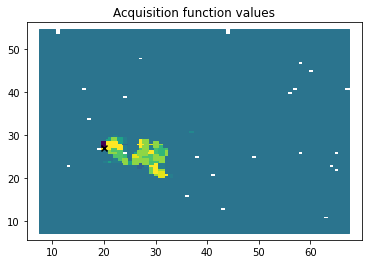

21/80


100%|██████████| 100/100 [00:02<00:00, 47.07it/s, init loss: 20150.1874, avg. loss [96-100]: 19063.6710]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.30820000000000003
noise            0.0762


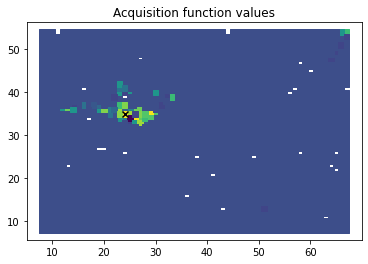

22/80


100%|██████████| 100/100 [00:02<00:00, 44.37it/s, init loss: 20151.6148, avg. loss [96-100]: 19084.1516]



Inferred GP kernel parameters
k_length         [1.8942 1.6148]
k_scale          0.2373
noise            0.0409


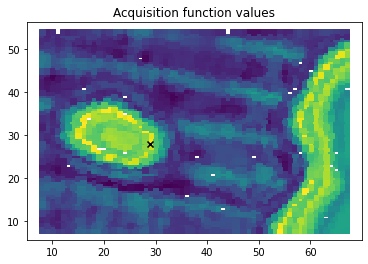

23/80


100%|██████████| 100/100 [00:02<00:00, 45.59it/s, init loss: 20152.9837, avg. loss [96-100]: 19064.3903]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3164
noise            0.0787


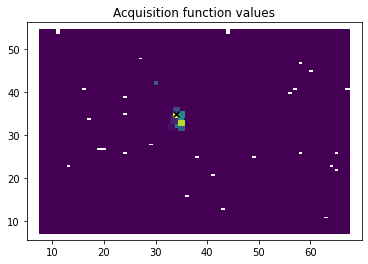

24/80


100%|██████████| 100/100 [00:02<00:00, 36.80it/s, init loss: 20154.2153, avg. loss [96-100]: 19064.4268]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3135
noise            0.078


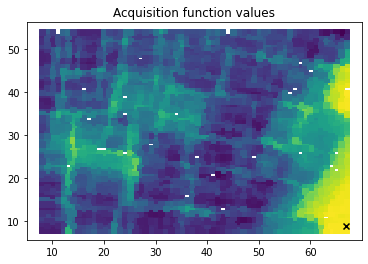

25/80


100%|██████████| 100/100 [00:02<00:00, 45.08it/s, init loss: 20155.4963, avg. loss [96-100]: 19088.3748]



Inferred GP kernel parameters
k_length         [2.2807 1.8435]
k_scale          0.22560000000000002
noise            0.0358


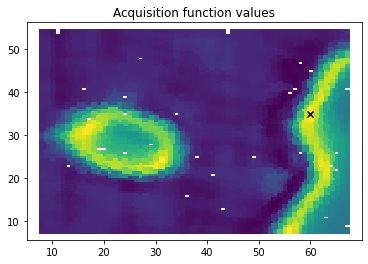

26/80


100%|██████████| 100/100 [00:02<00:00, 42.59it/s, init loss: 20156.8812, avg. loss [96-100]: 19064.2338]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3175
noise            0.0752


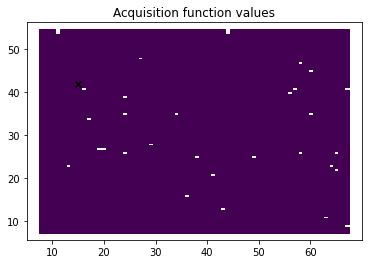

27/80


100%|██████████| 100/100 [00:02<00:00, 39.20it/s, init loss: 20158.1055, avg. loss [96-100]: 19102.3623]



Inferred GP kernel parameters
k_length         [2.9079 3.2538]
k_scale          0.2026
noise            0.0349


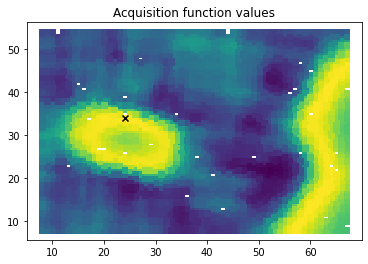

28/80


100%|██████████| 100/100 [00:02<00:00, 44.15it/s, init loss: 20159.3892, avg. loss [96-100]: 19116.3240]



Inferred GP kernel parameters
k_length         [4.3595 3.338 ]
k_scale          0.2291
noise            0.0379


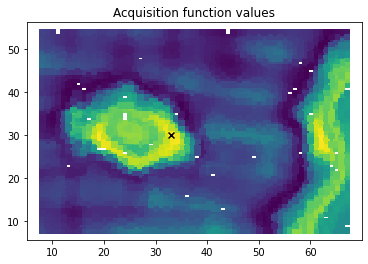

29/80


100%|██████████| 100/100 [00:02<00:00, 44.45it/s, init loss: 20160.6988, avg. loss [96-100]: 19074.7616]



Inferred GP kernel parameters
k_length         [2.2957 2.9906]
k_scale          0.2122
noise            0.030600000000000002


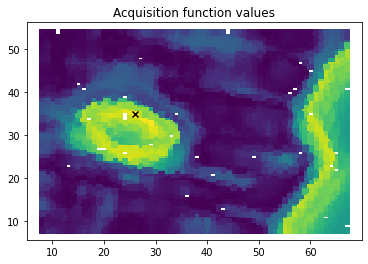

30/80


100%|██████████| 100/100 [00:02<00:00, 49.28it/s, init loss: 20161.9118, avg. loss [96-100]: 19065.5286]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3254
noise            0.0786


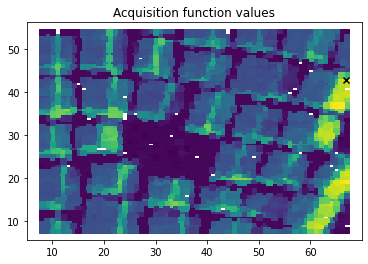

31/80


100%|██████████| 100/100 [00:02<00:00, 49.26it/s, init loss: 20163.2518, avg. loss [96-100]: 19097.7532]



Inferred GP kernel parameters
k_length         [3.114  3.4528]
k_scale          0.2083
noise            0.0303


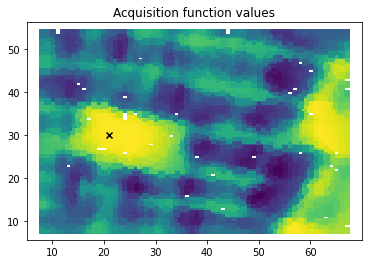

32/80


100%|██████████| 100/100 [00:02<00:00, 48.95it/s, init loss: 20164.4684, avg. loss [96-100]: 19102.3710]



Inferred GP kernel parameters
k_length         [3.1202 2.5325]
k_scale          0.2053
noise            0.0284


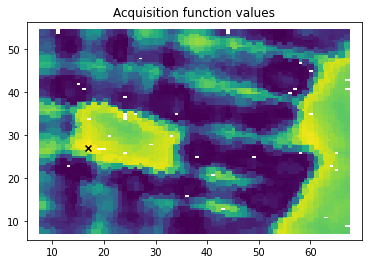

33/80


100%|██████████| 100/100 [00:02<00:00, 49.43it/s, init loss: 20165.6313, avg. loss [96-100]: 19065.4362]



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          0.3321
noise            0.076


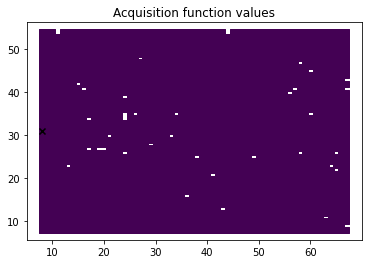

34/80


100%|██████████| 100/100 [00:02<00:00, 43.42it/s, init loss: 20166.9026, avg. loss [96-100]: 19093.9450]



Inferred GP kernel parameters
k_length         [3.3422 2.768 ]
k_scale          0.2086
noise            0.028300000000000002


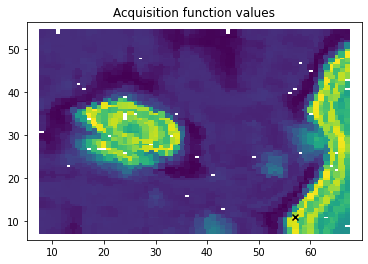

35/80


100%|██████████| 100/100 [00:02<00:00, 49.89it/s, init loss: 20168.3324, avg. loss [96-100]: 19110.6549]



Inferred GP kernel parameters
k_length         [3.5005 7.2206]
k_scale          0.2162
noise            0.0285


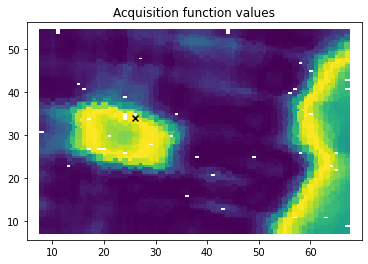

36/80


100%|██████████| 100/100 [00:02<00:00, 48.18it/s, init loss: 20169.5645, avg. loss [96-100]: 19109.1642]



Inferred GP kernel parameters
k_length         [3.8459 2.5623]
k_scale          0.2097
noise            0.0317


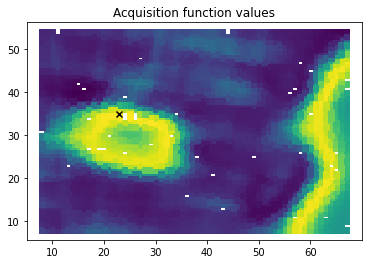

37/80


100%|██████████| 100/100 [00:02<00:00, 49.77it/s, init loss: 20170.9543, avg. loss [96-100]: 19070.3304]



Inferred GP kernel parameters
k_length         [3.9818 5.0427]
k_scale          0.2093
noise            0.026600000000000002


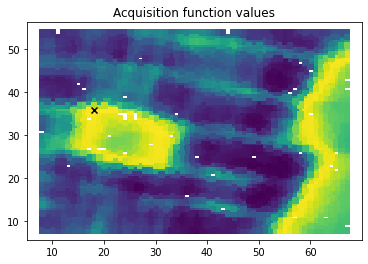

38/80


100%|██████████| 100/100 [00:02<00:00, 47.59it/s, init loss: 20172.1986, avg. loss [96-100]: 19112.8548]



Inferred GP kernel parameters
k_length         [4.3138 3.7613]
k_scale          0.2025
noise            0.030100000000000002


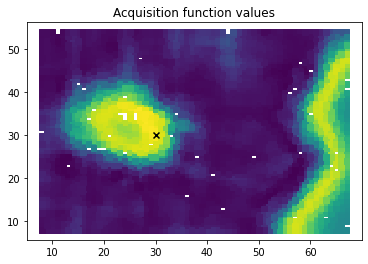

39/80


100%|██████████| 100/100 [00:02<00:00, 49.13it/s, init loss: 20173.6072, avg. loss [96-100]: 19057.7605]



Inferred GP kernel parameters
k_length         [3.8102 4.0559]
k_scale          0.2212
noise            0.022600000000000002


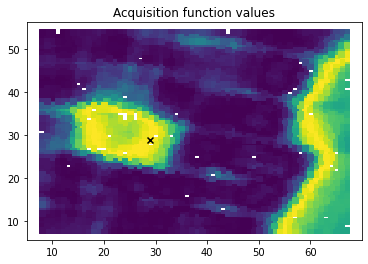

40/80


100%|██████████| 100/100 [00:02<00:00, 48.20it/s, init loss: 20174.9623, avg. loss [96-100]: 19055.0510]



Inferred GP kernel parameters
k_length         [2.2866 3.2954]
k_scale          0.25
noise            0.0204


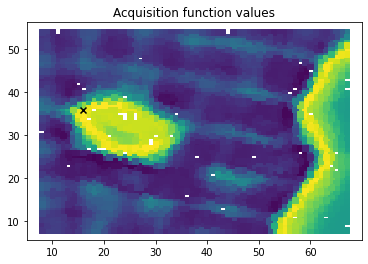

41/80


100%|██████████| 100/100 [00:02<00:00, 43.60it/s, init loss: 20176.3838, avg. loss [96-100]: 19085.1252]



Inferred GP kernel parameters
k_length         [3.1929 3.7062]
k_scale          0.22710000000000002
noise            0.027200000000000002


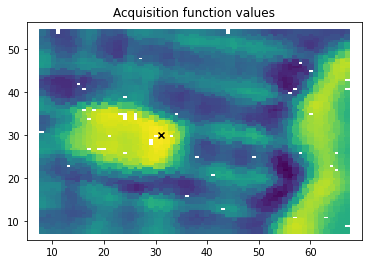

42/80


100%|██████████| 100/100 [00:02<00:00, 49.32it/s, init loss: 20177.7244, avg. loss [96-100]: 19063.2745]



Inferred GP kernel parameters
k_length         [3.3648 5.7335]
k_scale          0.249
noise            0.0241


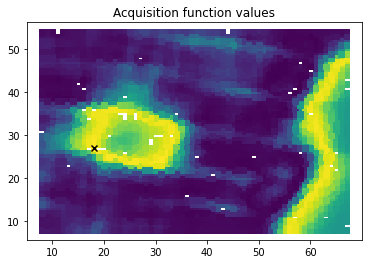

43/80


100%|██████████| 100/100 [00:02<00:00, 48.63it/s, init loss: 20178.9928, avg. loss [96-100]: 19086.9356]



Inferred GP kernel parameters
k_length         [5.4179 5.3703]
k_scale          0.23420000000000002
noise            0.026000000000000002


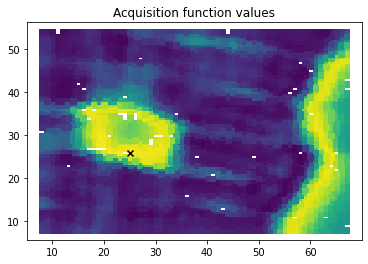

44/80


100%|██████████| 100/100 [00:02<00:00, 48.71it/s, init loss: 20180.2508, avg. loss [96-100]: 19058.8322]



Inferred GP kernel parameters
k_length         [4.374  2.7179]
k_scale          0.23340000000000002
noise            0.0224


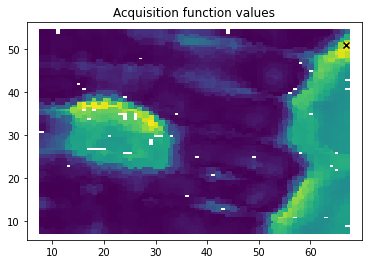

45/80


100%|██████████| 100/100 [00:02<00:00, 42.98it/s, init loss: 20181.4756, avg. loss [96-100]: 19156.0886]



Inferred GP kernel parameters
k_length         [6.0623 5.8263]
k_scale          0.21530000000000002
noise            0.027100000000000003


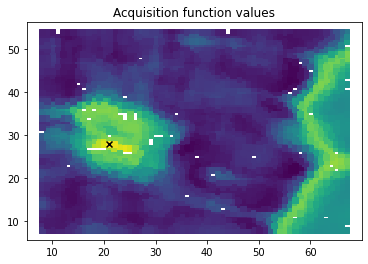

46/80


100%|██████████| 100/100 [00:02<00:00, 48.57it/s, init loss: 20182.6302, avg. loss [96-100]: 19070.1547]



Inferred GP kernel parameters
k_length         [5.0221 3.5374]
k_scale          0.21080000000000002
noise            0.022500000000000003


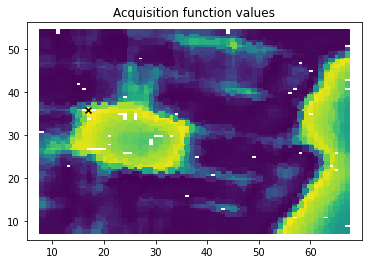

47/80


100%|██████████| 100/100 [00:01<00:00, 50.08it/s, init loss: 20183.9311, avg. loss [96-100]: 19160.3243]



Inferred GP kernel parameters
k_length         [4.661  4.0324]
k_scale          0.2325
noise            0.027200000000000002


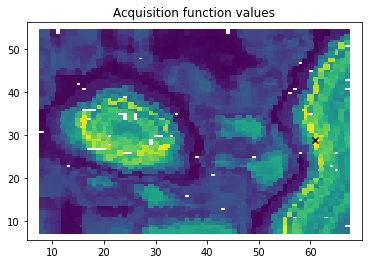

48/80


100%|██████████| 100/100 [00:02<00:00, 42.18it/s, init loss: 20185.1951, avg. loss [96-100]: 19073.6622]



Inferred GP kernel parameters
k_length         [3.8842 4.7834]
k_scale          0.22440000000000002
noise            0.0222


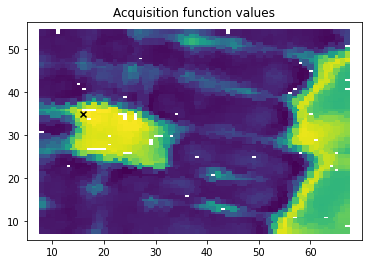

49/80


100%|██████████| 100/100 [00:02<00:00, 48.70it/s, init loss: 20186.5319, avg. loss [96-100]: 19082.5243]



Inferred GP kernel parameters
k_length         [5.0422 4.2408]
k_scale          0.2015
noise            0.0234


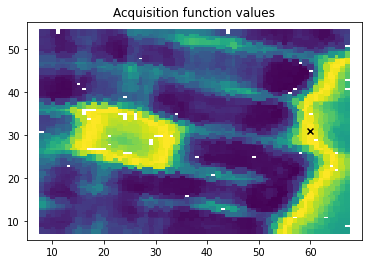

50/80


100%|██████████| 100/100 [00:02<00:00, 48.53it/s, init loss: 20187.7909, avg. loss [96-100]: 19088.8517]



Inferred GP kernel parameters
k_length         [4.0237 7.4554]
k_scale          0.19
noise            0.0219


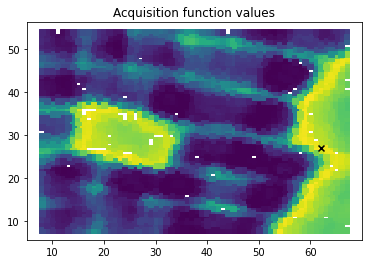

51/80


100%|██████████| 100/100 [00:02<00:00, 49.34it/s, init loss: 20189.1062, avg. loss [96-100]: 19073.0299]



Inferred GP kernel parameters
k_length         [5.7277 5.3131]
k_scale          0.1938
noise            0.023100000000000002


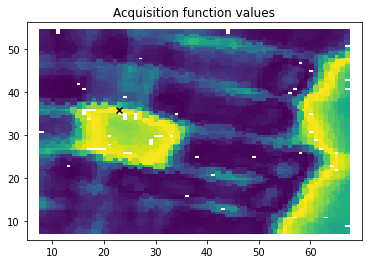

52/80


100%|██████████| 100/100 [00:02<00:00, 41.01it/s, init loss: 20190.4408, avg. loss [96-100]: 19046.1078]



Inferred GP kernel parameters
k_length         [2.729 3.769]
k_scale          0.2154
noise            0.0181


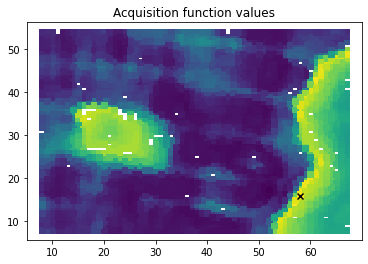

53/80


100%|██████████| 100/100 [00:02<00:00, 49.41it/s, init loss: 20191.7580, avg. loss [96-100]: 19060.1076]



Inferred GP kernel parameters
k_length         [4.9001 2.6238]
k_scale          0.22240000000000001
noise            0.0204


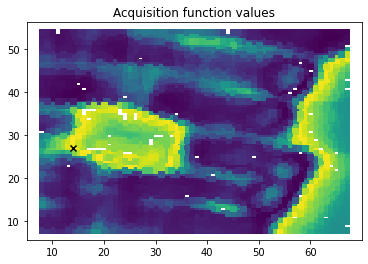

54/80


100%|██████████| 100/100 [00:02<00:00, 47.99it/s, init loss: 20193.0524, avg. loss [96-100]: 19098.2837]



Inferred GP kernel parameters
k_length         [6.023  6.1871]
k_scale          0.1918
noise            0.0224


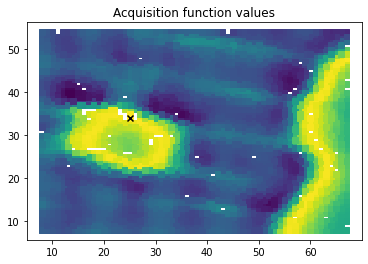

55/80


100%|██████████| 100/100 [00:02<00:00, 48.51it/s, init loss: 20194.4143, avg. loss [96-100]: 19077.7967]



Inferred GP kernel parameters
k_length         [4.4921 8.3982]
k_scale          0.21080000000000002
noise            0.0222


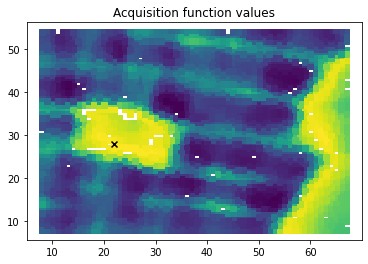

56/80


100%|██████████| 100/100 [00:02<00:00, 42.25it/s, init loss: 20195.6613, avg. loss [96-100]: 19055.7549]



Inferred GP kernel parameters
k_length         [7.1363 7.2028]
k_scale          0.22460000000000002
noise            0.0199


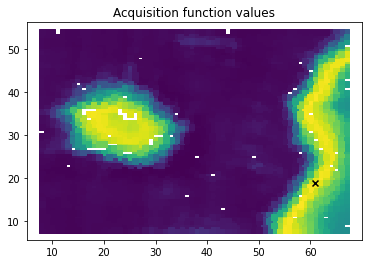

57/80


100%|██████████| 100/100 [00:02<00:00, 48.91it/s, init loss: 20197.0407, avg. loss [96-100]: 19113.1939]



Inferred GP kernel parameters
k_length         [3.791  3.4522]
k_scale          0.1835
noise            0.017


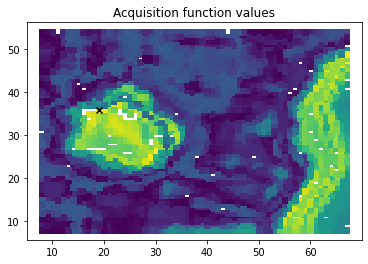

58/80


100%|██████████| 100/100 [00:02<00:00, 48.86it/s, init loss: 20198.1941, avg. loss [96-100]: 19046.4783]



Inferred GP kernel parameters
k_length         [4.7253 4.1428]
k_scale          0.2036
noise            0.019700000000000002


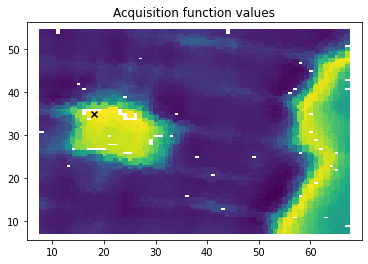

59/80


100%|██████████| 100/100 [00:02<00:00, 49.25it/s, init loss: 20199.3934, avg. loss [96-100]: 19050.8117]



Inferred GP kernel parameters
k_length         [2.5176 3.9839]
k_scale          0.21860000000000002
noise            0.0155


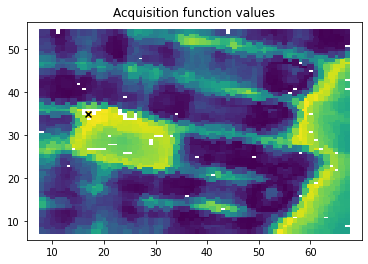

60/80


100%|██████████| 100/100 [00:02<00:00, 47.42it/s, init loss: 20200.5877, avg. loss [96-100]: 19106.4145]



Inferred GP kernel parameters
k_length         [6.7153 6.4607]
k_scale          0.2056
noise            0.0222


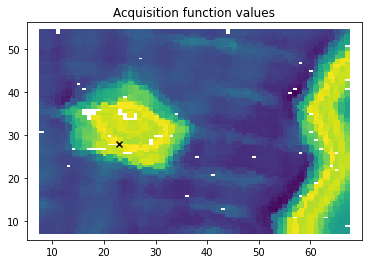

61/80


100%|██████████| 100/100 [00:01<00:00, 50.21it/s, init loss: 20201.7963, avg. loss [96-100]: 19052.9362]



Inferred GP kernel parameters
k_length         [4.8905 5.6957]
k_scale          0.1995
noise            0.0206


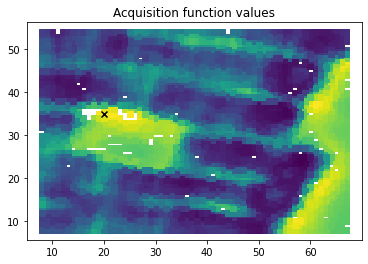

62/80


100%|██████████| 100/100 [00:02<00:00, 48.43it/s, init loss: 20203.1824, avg. loss [96-100]: 19137.5382]



Inferred GP kernel parameters
k_length         [ 9.6951 10.4816]
k_scale          0.1963
noise            0.0273


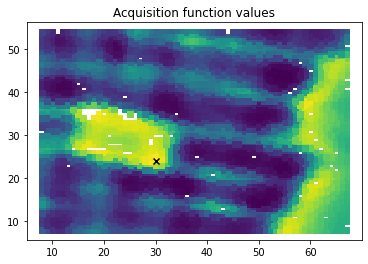

63/80


100%|██████████| 100/100 [00:02<00:00, 49.57it/s, init loss: 20204.5602, avg. loss [96-100]: 19076.2165]



Inferred GP kernel parameters
k_length         [8.0585 4.8082]
k_scale          0.18510000000000001
noise            0.019


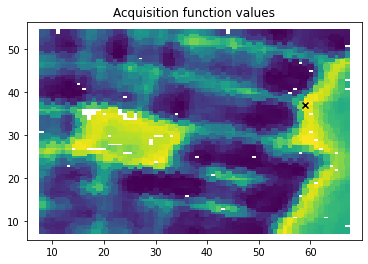

64/80


100%|██████████| 100/100 [00:02<00:00, 48.33it/s, init loss: 20205.7969, avg. loss [96-100]: 19092.7150]



Inferred GP kernel parameters
k_length         [8.3036 7.1512]
k_scale          0.1998
noise            0.0211


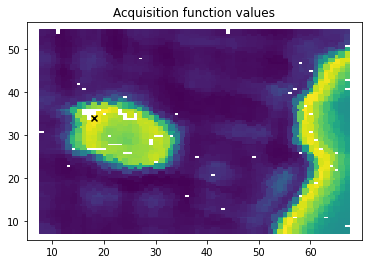

65/80


100%|██████████| 100/100 [00:01<00:00, 50.12it/s, init loss: 20207.0503, avg. loss [96-100]: 19082.3645]



Inferred GP kernel parameters
k_length         [8.0691 6.383 ]
k_scale          0.18130000000000002
noise            0.0228


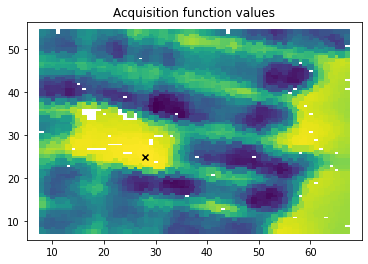

66/80


100%|██████████| 100/100 [00:02<00:00, 48.11it/s, init loss: 20208.4335, avg. loss [96-100]: 19058.0242]



Inferred GP kernel parameters
k_length         [4.5186 4.2823]
k_scale          0.20720000000000002
noise            0.0176


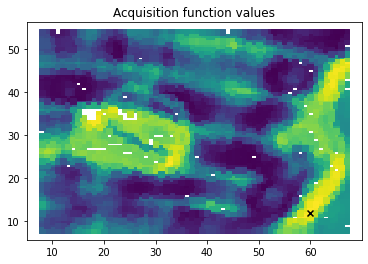

67/80


100%|██████████| 100/100 [00:02<00:00, 49.73it/s, init loss: 20209.7103, avg. loss [96-100]: 19052.9587]



Inferred GP kernel parameters
k_length         [5.0549 5.0014]
k_scale          0.19260000000000002
noise            0.0165


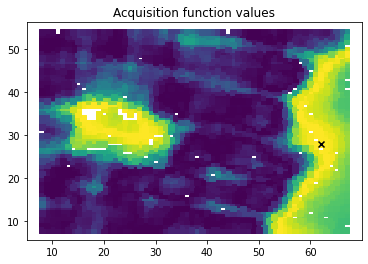

68/80


100%|██████████| 100/100 [00:02<00:00, 47.76it/s, init loss: 20210.9513, avg. loss [96-100]: 19074.6191]



Inferred GP kernel parameters
k_length         [3.7765 4.0226]
k_scale          0.2092
noise            0.017400000000000002


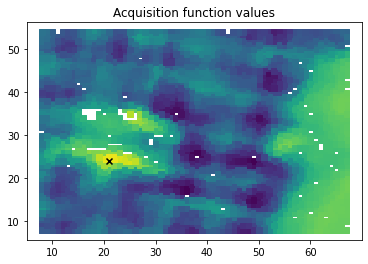

69/80


100%|██████████| 100/100 [00:02<00:00, 49.19it/s, init loss: 20212.1501, avg. loss [96-100]: 19155.3055]



Inferred GP kernel parameters
k_length         [7.4488 6.7159]
k_scale          0.1993
noise            0.0195


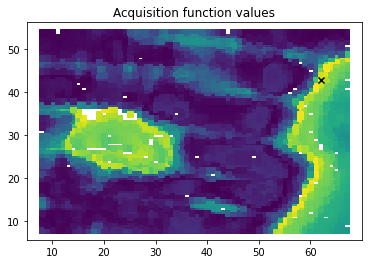

70/80


100%|██████████| 100/100 [00:02<00:00, 49.25it/s, init loss: 20213.4097, avg. loss [96-100]: 19085.8647]



Inferred GP kernel parameters
k_length         [8.0686 7.3859]
k_scale          0.187
noise            0.0189


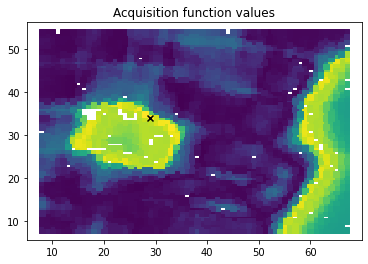

71/80


100%|██████████| 100/100 [00:02<00:00, 49.57it/s, init loss: 20214.6759, avg. loss [96-100]: 19101.5190]



Inferred GP kernel parameters
k_length         [7.4345 7.1794]
k_scale          0.18560000000000001
noise            0.0195


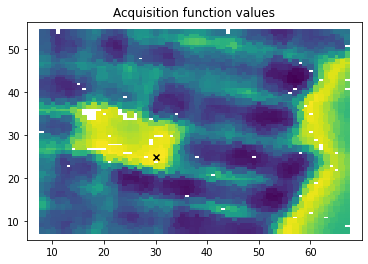

72/80


100%|██████████| 100/100 [00:02<00:00, 48.24it/s, init loss: 20216.0592, avg. loss [96-100]: 19064.0825]



Inferred GP kernel parameters
k_length         [8.2213 7.4226]
k_scale          0.21080000000000002
noise            0.0196


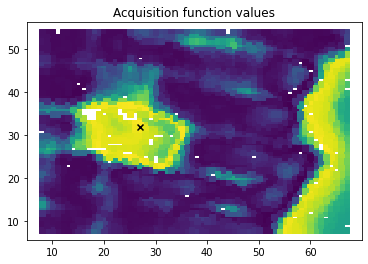

73/80


100%|██████████| 100/100 [00:02<00:00, 48.95it/s, init loss: 20217.3857, avg. loss [96-100]: 19070.0517]



Inferred GP kernel parameters
k_length         [4.6116 6.1971]
k_scale          0.1837
noise            0.016300000000000002


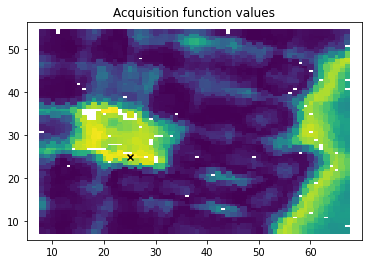

74/80


100%|██████████| 100/100 [00:02<00:00, 47.87it/s, init loss: 20218.6206, avg. loss [96-100]: 19070.8472]



Inferred GP kernel parameters
k_length         [5.2645 7.4058]
k_scale          0.1927
noise            0.0172


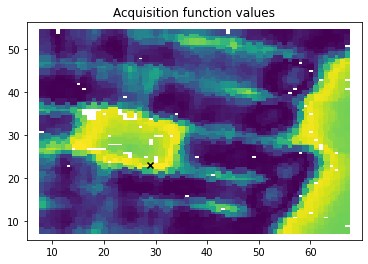

75/80


100%|██████████| 100/100 [00:02<00:00, 49.01it/s, init loss: 20219.8553, avg. loss [96-100]: 19084.0562]



Inferred GP kernel parameters
k_length         [5.6549 6.9358]
k_scale          0.18080000000000002
noise            0.0178


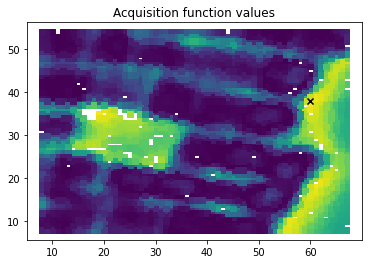

76/80


100%|██████████| 100/100 [00:02<00:00, 48.02it/s, init loss: 20221.2520, avg. loss [96-100]: 19073.4720]



Inferred GP kernel parameters
k_length         [3.4157 3.4377]
k_scale          0.22820000000000001
noise            0.016300000000000002


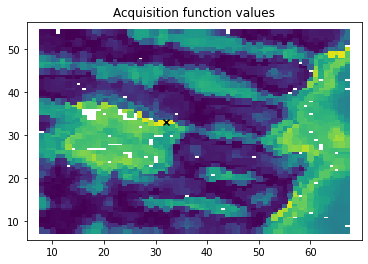

77/80


100%|██████████| 100/100 [00:02<00:00, 49.48it/s, init loss: 20222.4520, avg. loss [96-100]: 19123.8589]



Inferred GP kernel parameters
k_length         [ 8.8841 10.3219]
k_scale          0.1746
noise            0.022600000000000002


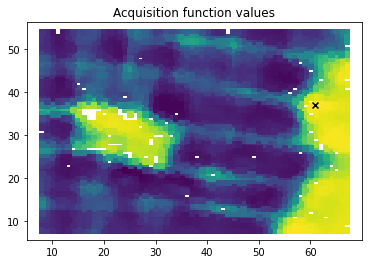

78/80


100%|██████████| 100/100 [00:02<00:00, 48.89it/s, init loss: 20223.7977, avg. loss [96-100]: 19126.2257]



Inferred GP kernel parameters
k_length         [ 8.9796 10.439 ]
k_scale          0.19410000000000002
noise            0.02


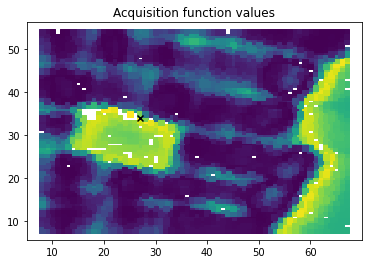

79/80


100%|██████████| 100/100 [00:02<00:00, 49.14it/s, init loss: 20225.2006, avg. loss [96-100]: 19106.6018]



Inferred GP kernel parameters
k_length         [6.6709 8.6823]
k_scale          0.1739
noise            0.019200000000000002


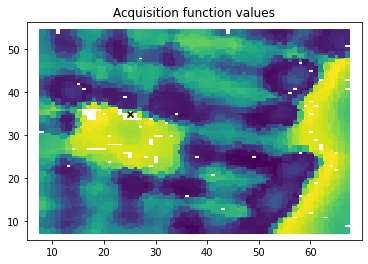

80/80


100%|██████████| 100/100 [00:02<00:00, 47.45it/s, init loss: 20226.5918, avg. loss [96-100]: 19074.7413]



Inferred GP kernel parameters
k_length         [11.8922  8.7642]
k_scale          0.1899
noise            0.0198


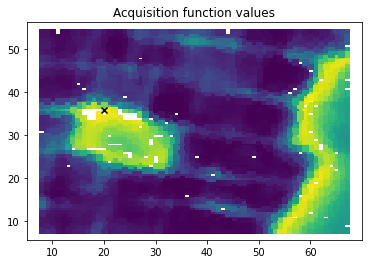

In [24]:
def plot_result(indices, obj):
    plt.scatter(indices[:, 1], indices[:, 0], s=32, c=obj, marker='s')
    next_point = indices_test[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], marker='x', c='k')
    plt.title("Acquisition function values")
    plt.show()


data_dim = X_train.shape[-1]

exploration_steps = 80

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(key1, X_train, y_train, num_steps=100, step_size=0.05)
    # Compute UCB acquisition function
    obj = gpax.acquisition.UCB(key2, dkl, X_test, beta=4, maximize=True)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

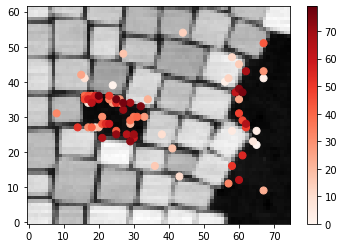

In [25]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

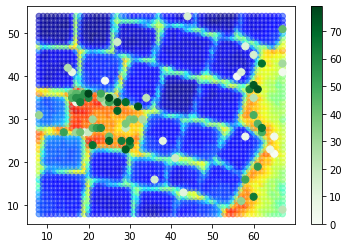

In [26]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Greens")
plt.colorbar()

Looks like it did a pretty good job identifying the regions where a physical behavior of interest is maximized.

## Active ensemble learning

Now let's repeat the active learning experiment, but this time we are going to use an ensemble of deep learning models instead of a single one. It is well known in the field of deep/machine learning that ensembles of models tend to provide more accurate predictions and more reliable uncertainty estimates.

In GPax, we can train an ensemble of models using a ```fit_predict``` method where we just have to specify the number of models (```n_models```) in the ensemble. Then, we can compute the acquisition function using the DKL output averaged over the ensemble models.

1/80


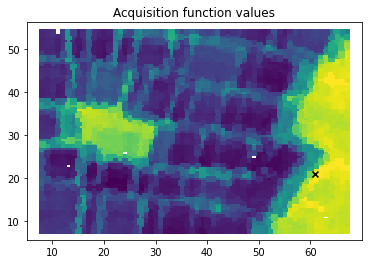

2/80


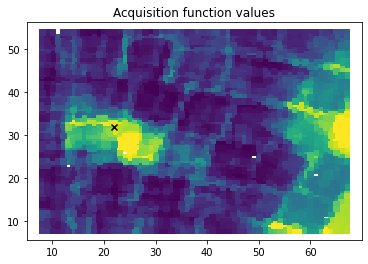

3/80


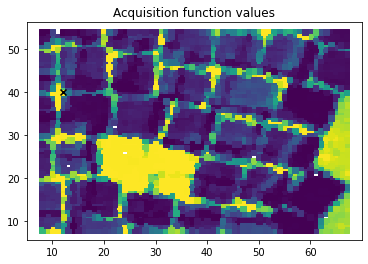

4/80


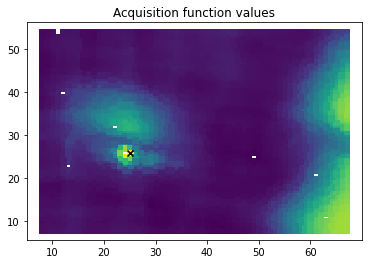

5/80


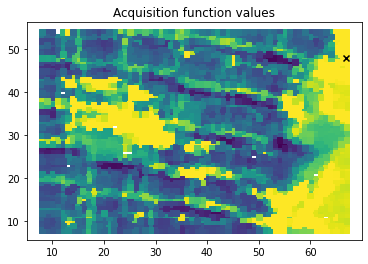

6/80


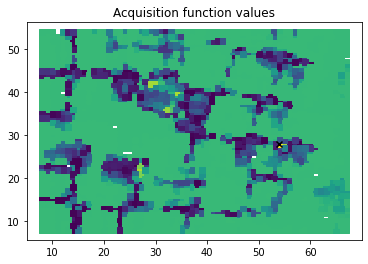

7/80


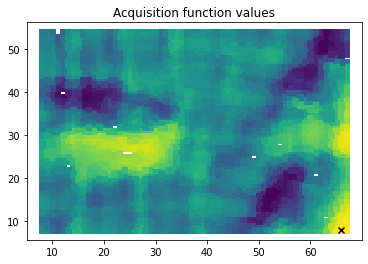

8/80


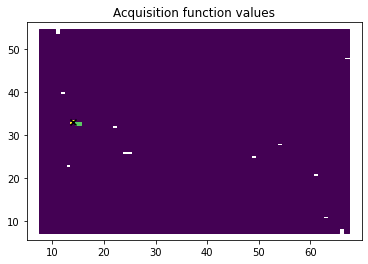

9/80


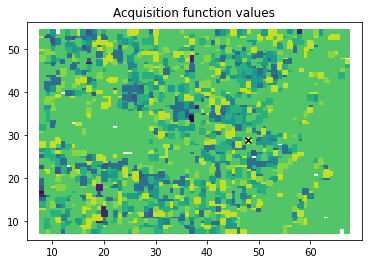

10/80


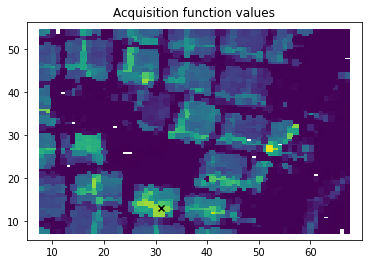

11/80


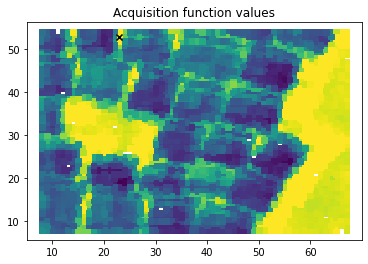

12/80


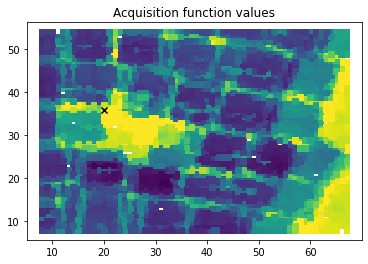

13/80


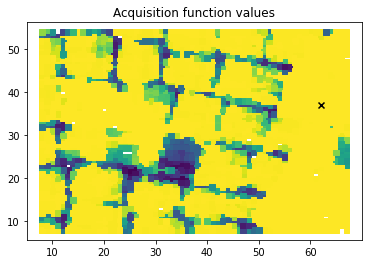

14/80


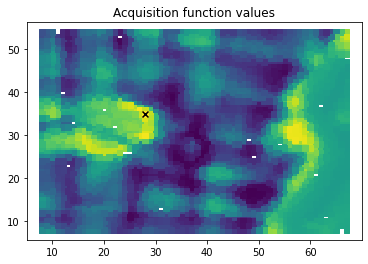

15/80


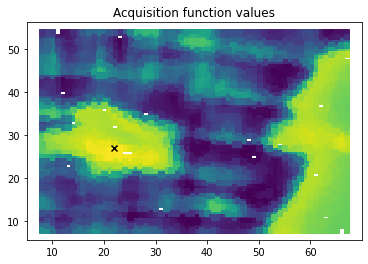

16/80


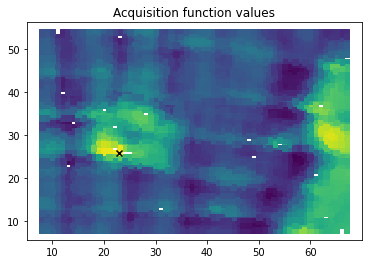

17/80


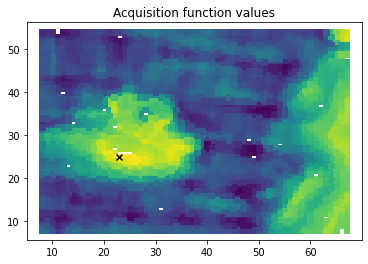

18/80


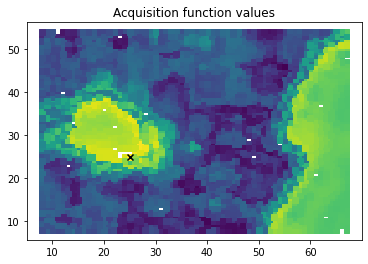

19/80


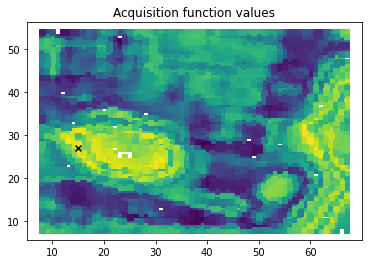

20/80


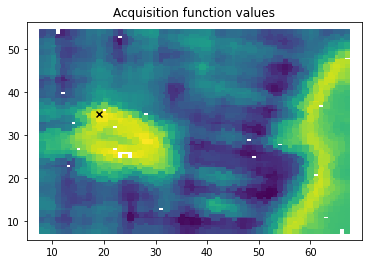

21/80


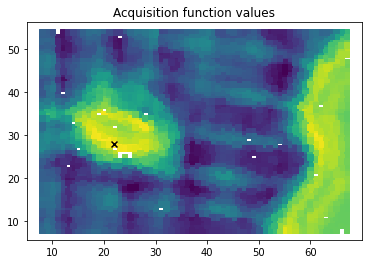

22/80


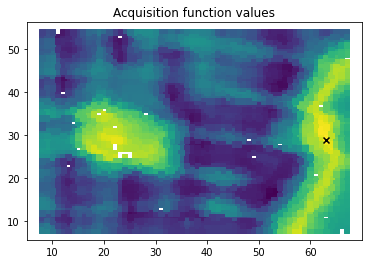

23/80


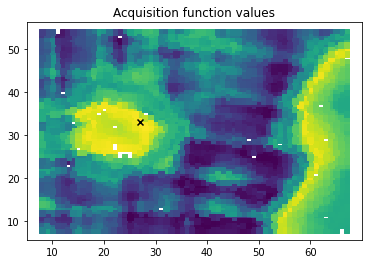

24/80


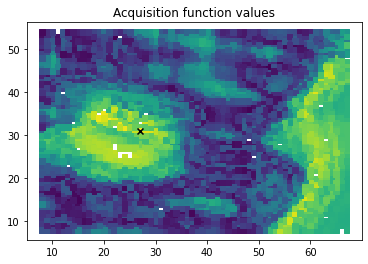

25/80


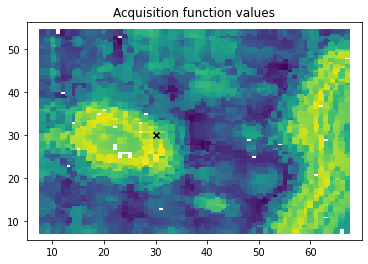

26/80


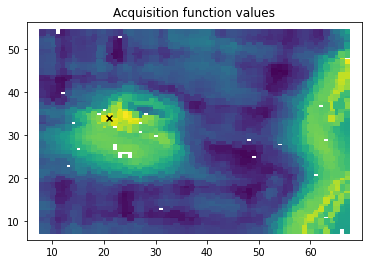

27/80


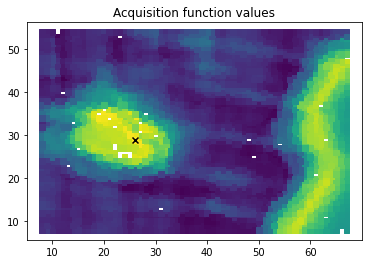

28/80


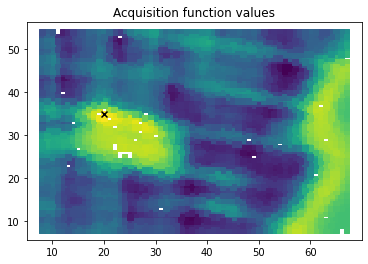

29/80


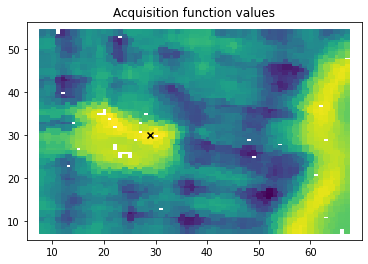

30/80


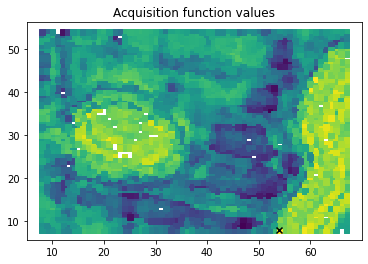

31/80


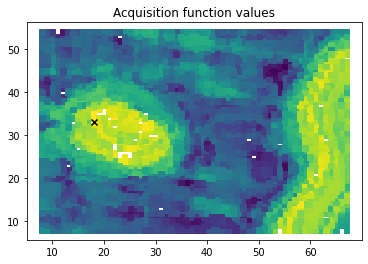

32/80


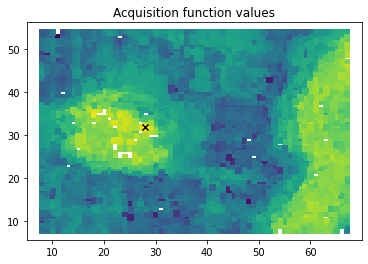

33/80


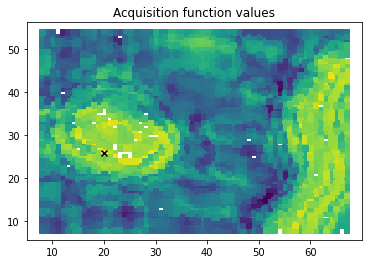

34/80


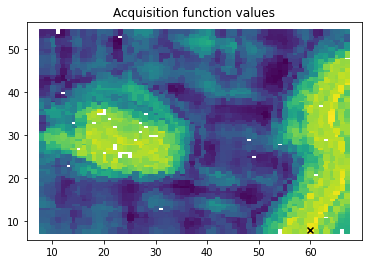

35/80


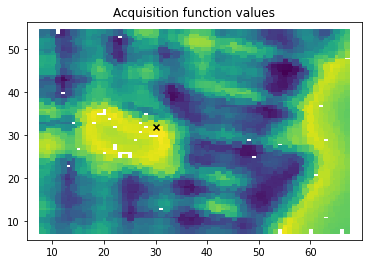

36/80


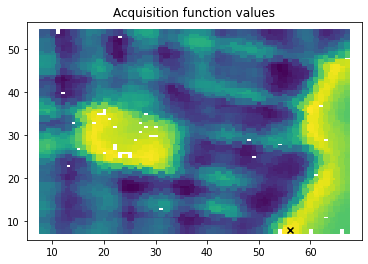

37/80


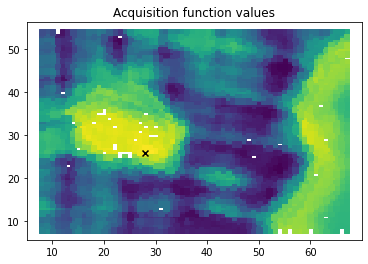

38/80


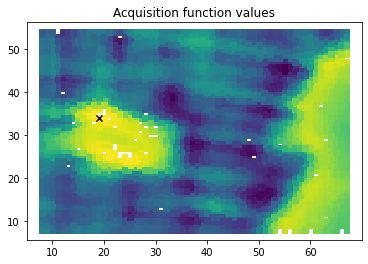

39/80


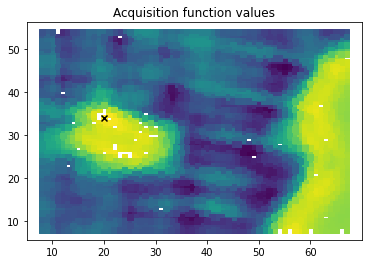

40/80


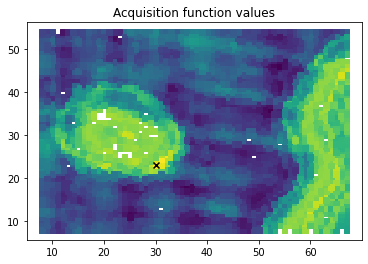

41/80


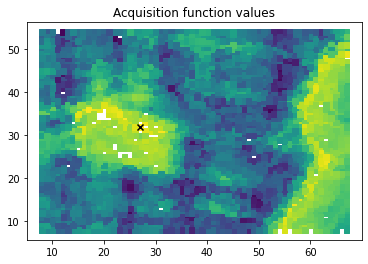

42/80


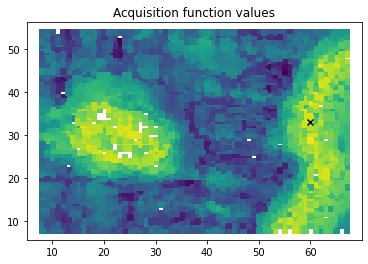

43/80


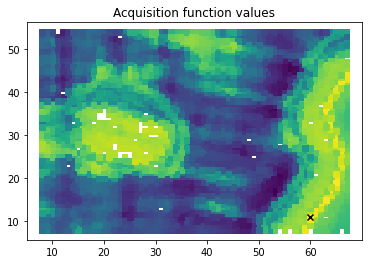

44/80


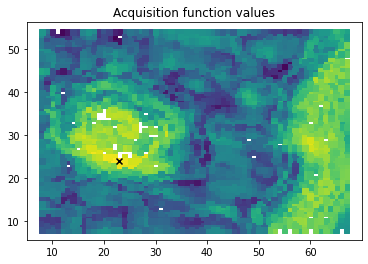

45/80


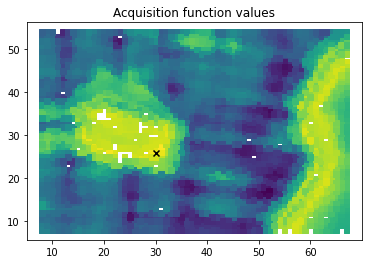

46/80


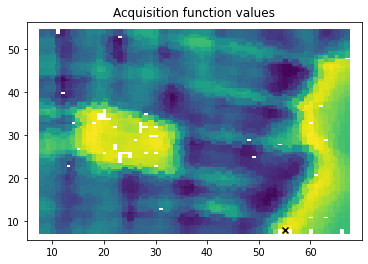

47/80


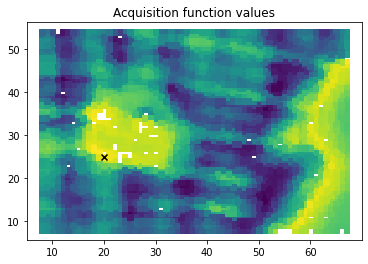

48/80


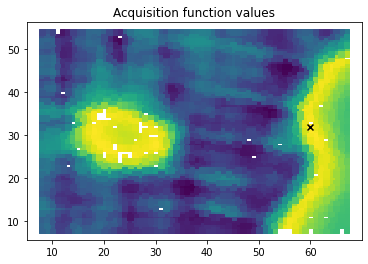

49/80


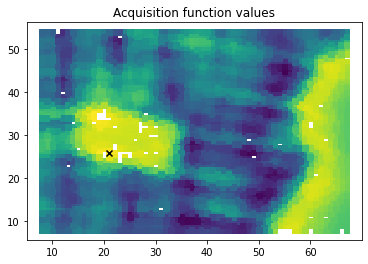

50/80


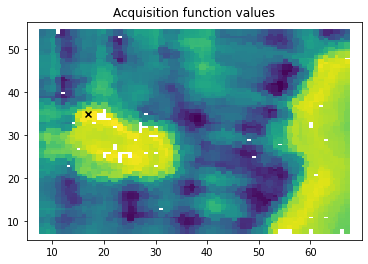

51/80


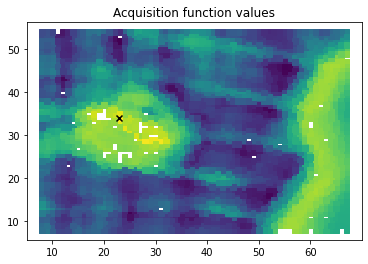

52/80


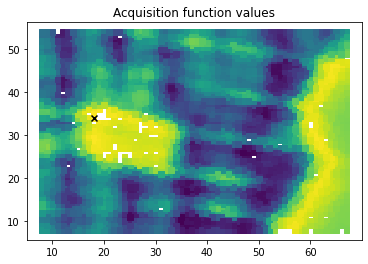

53/80


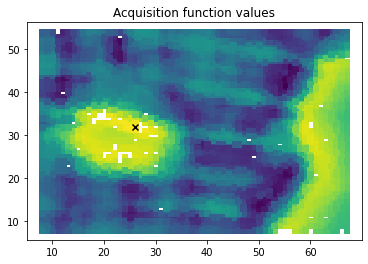

54/80


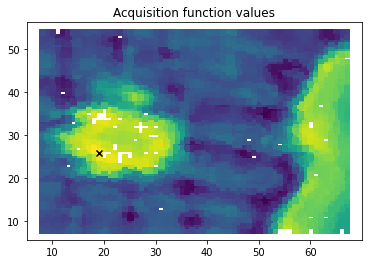

55/80


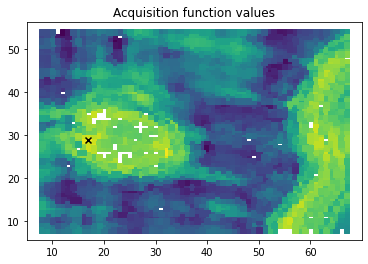

56/80


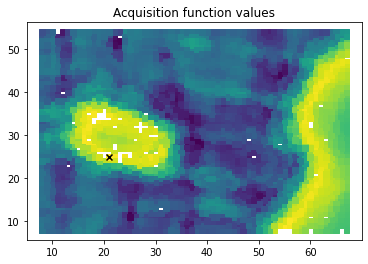

57/80


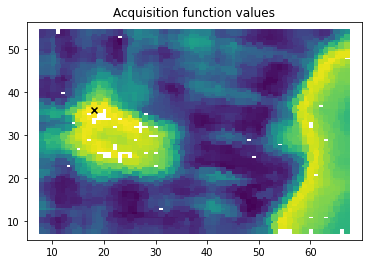

58/80


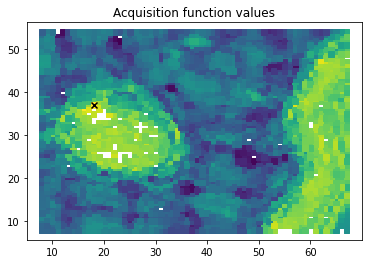

59/80


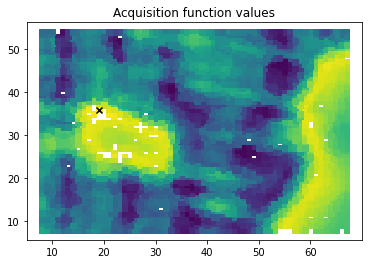

60/80


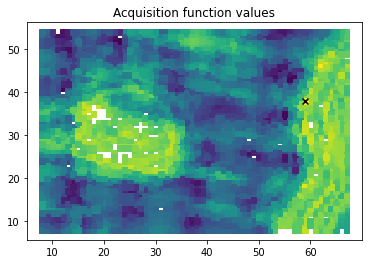

61/80


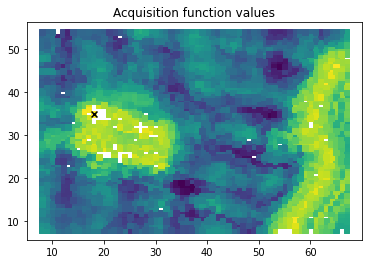

62/80


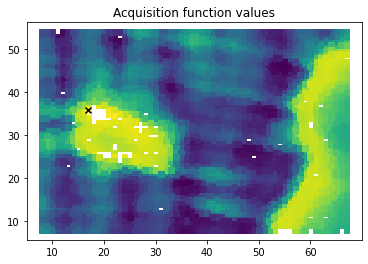

63/80


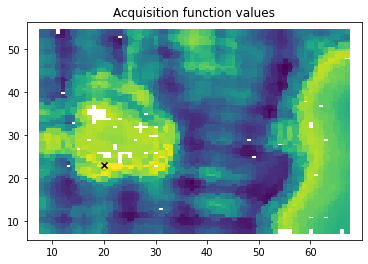

64/80


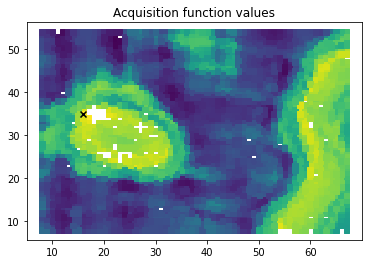

65/80


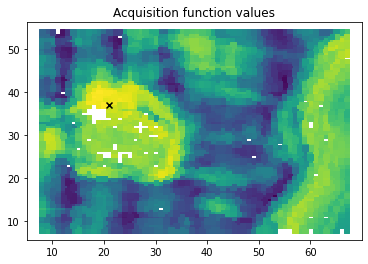

66/80


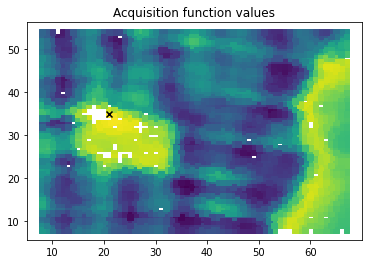

67/80


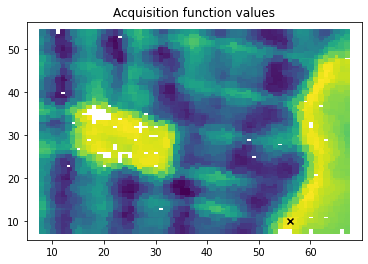

68/80


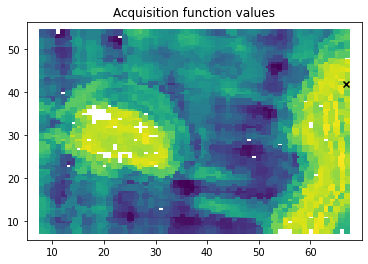

69/80


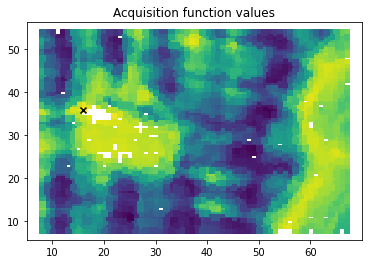

70/80


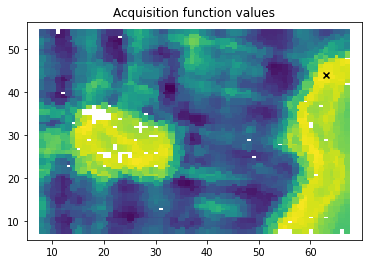

71/80


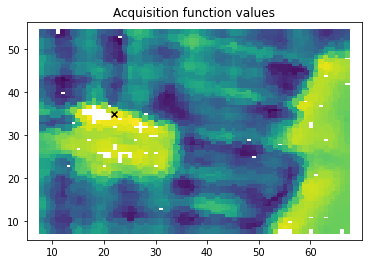

72/80


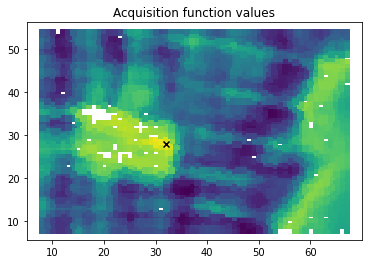

73/80


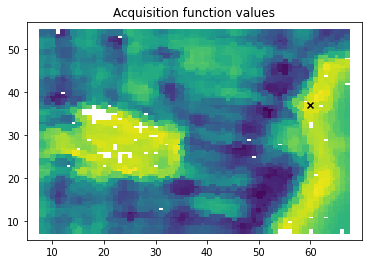

74/80


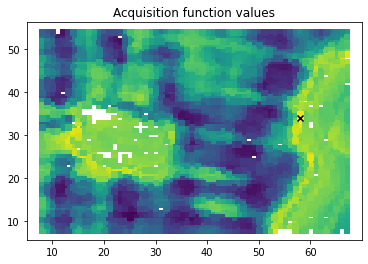

75/80


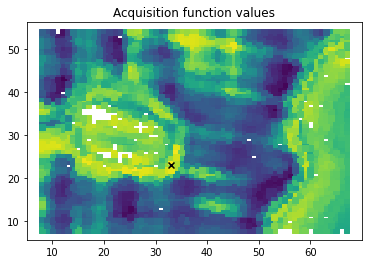

76/80


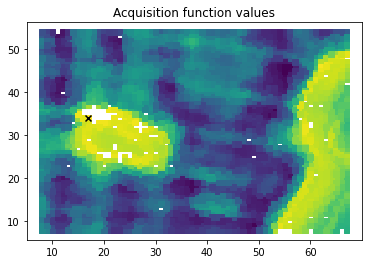

77/80


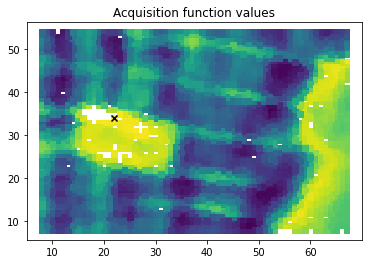

78/80


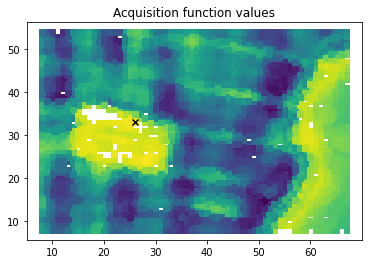

79/80


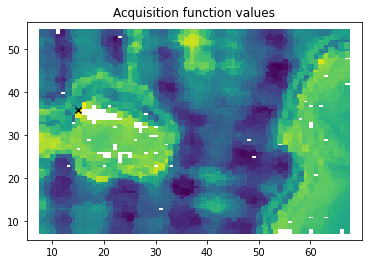

80/80


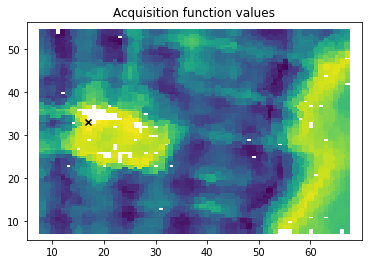

In [27]:
(X_train, X_test, y_train, y_test,
  indices_train, indices_test) = train_test_split(
      X, y, indices_all, test_size=0.998, shuffle=True, random_state=1)
  
seed_points = len(X_train)


exploration_steps = 80

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # update GP posterior
    dkl = gpax.viDKL(data_dim, 2)
    mu_all, var_all = dkl.fit_predict(  # train an ensemble of 5 DKL models
        key1, X_train, y_train, X_test, n_models=5, num_steps=100, step_size=0.05)
    # average over ensemble predictions
    mu = mu_all.mean(0)
    sig = np.sqrt(var_all.mean(0))  # standard deviation
    # Compute UCB acquisition function (equivalent to the one above)
    obj = mu + 2 * sig
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_result(indices_test, obj)
    # Append to the arrays of measured points
    X_train = np.append(X_train, X_test[next_point_idx][None], 0)
    X_test = np.delete(X_test, next_point_idx, 0)
    y_train = np.append(y_train, measured_point)
    y_test = np.delete(y_test, next_point_idx)
    indices_train = np.append(indices_train, next_point[None], 0)
    indices_test = np.delete(indices_test, next_point_idx, 0)

Show results on top of the structural data:

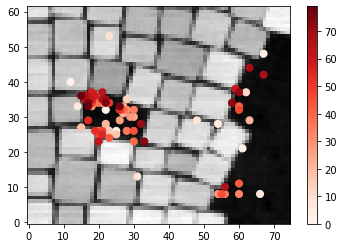

In [28]:
plt.imshow(img, origin="lower", cmap='gray')
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Reds")
plt.colorbar()

Overlay with a 'ground truth':

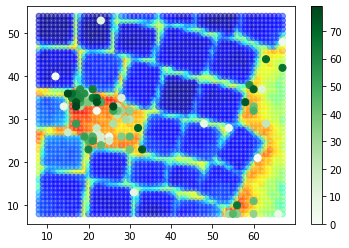

In [29]:
plt.scatter(indices_all[:, 1], indices_all[:, 0], c=peaks_all, cmap='jet', alpha=0.5)
plt.scatter(indices_train[seed_points:, 1], indices_train[seed_points:, 0],
            c=np.arange(len(indices_train[seed_points:])), s=50, cmap="Greens")
plt.colorbar()